In [ ]:
!pip install shap

In [ ]:
!pip install bayesian-optimization

In [3]:
import numpy as np
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
def metrics(model):
  R2_test = r2_score(y_test, model.predict(X_test))
  print("R2 Score(Test): {:.5f}".format(R2_test))
  R2_train = r2_score(y_train, model.predict(X_train))
  print("R2 Score(Train): {:.5f}".format(R2_train))
  mse_test = mean_squared_error(y_test, model.predict(X_test))
  print("MSE(Test): {:.5f}".format(mse_test))
  mse_train = mean_squared_error(y_train, model.predict(X_train))
  print("MSE(Train): {:.5f}".format(mse_train))
  mae_test = mean_absolute_error(y_test, model.predict(X_test))
  print("MAE(Test): {:.5f}".format(mae_test))
  mae_train = mean_absolute_error(y_train, model.predict(X_train))
  print("MAE(Train): {:.5f}".format(mae_train))
  rmse_test = np.sqrt(np.mean((y_test - model.predict(X_test)) ** 2))
  print("RMSE(Test): {:.5f}".format(rmse_test))
  rmse_train = np.sqrt(np.mean((y_train - model.predict(X_train)) ** 2))
  print("RMSE(Train): {:.5f}".format(rmse_train))

In [6]:
Paper1 = pd.read_excel('/content/XRD.xlsx',sheet_name='XRD')
X = Paper1.drop('delta(eff)', axis=1)
y = Paper1['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

In [ ]:
#Optimization_XGBoost_Regressor
def objective(learning_rate,n_estimators,reg_lambda,alpha):
    model = XGBRegressor(learning_rate=learning_rate,
                         n_estimators=int(n_estimators),
                         reg_lambda = reg_lambda,
                         alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
#===============================================================================
pbounds = {
    'learning_rate': (0.02, 0.045),
    'n_estimators': (300, 500),
    'reg_lambda' : (0.1,1),
    'alpha': (0,0.8)
}
#===============================================================================
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=78,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
)

In [7]:
model= XGBRegressor(alpha=0.02752, reg_lambda=0.9295, n_estimators=315, learning_rate= 0.04316)
model.fit(X_train, y_train);
metrics(model)

R2 Score(Test): 0.96062
R2 Score(Train): 0.96903
MSE(Test): 0.01988
MSE(Train): 0.01469
MAE(Test): 0.10540
MAE(Train): 0.06749
RMSE(Test): 0.14099
RMSE(Train): 0.12122


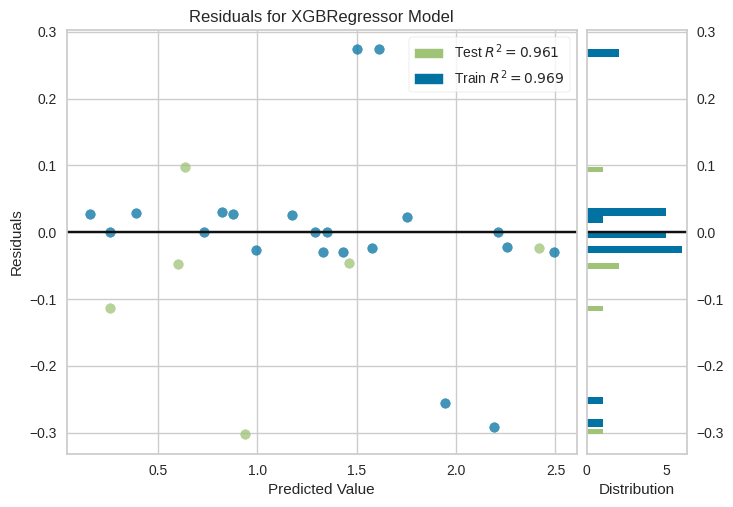

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [8]:
visualizer = ResidualsPlot(model)
visualizer.score(X_test,y_test)
visualizer.fit(X_train,y_train)
visualizer.show()

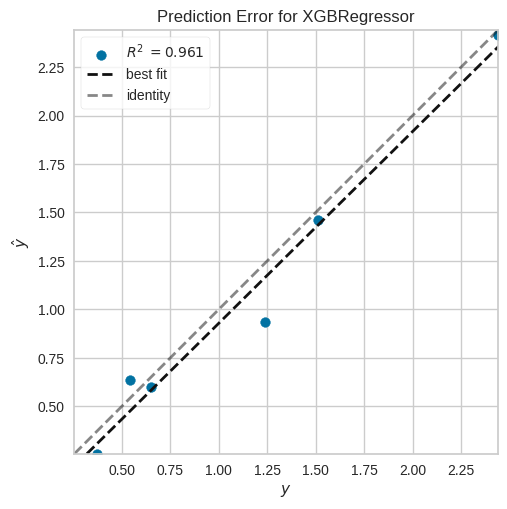

<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [9]:
visualizer = PredictionError(model,alpha=1)
visualizer.score(X_test,y_test)
visualizer.fit(X_train,y_train)
visualizer.show()

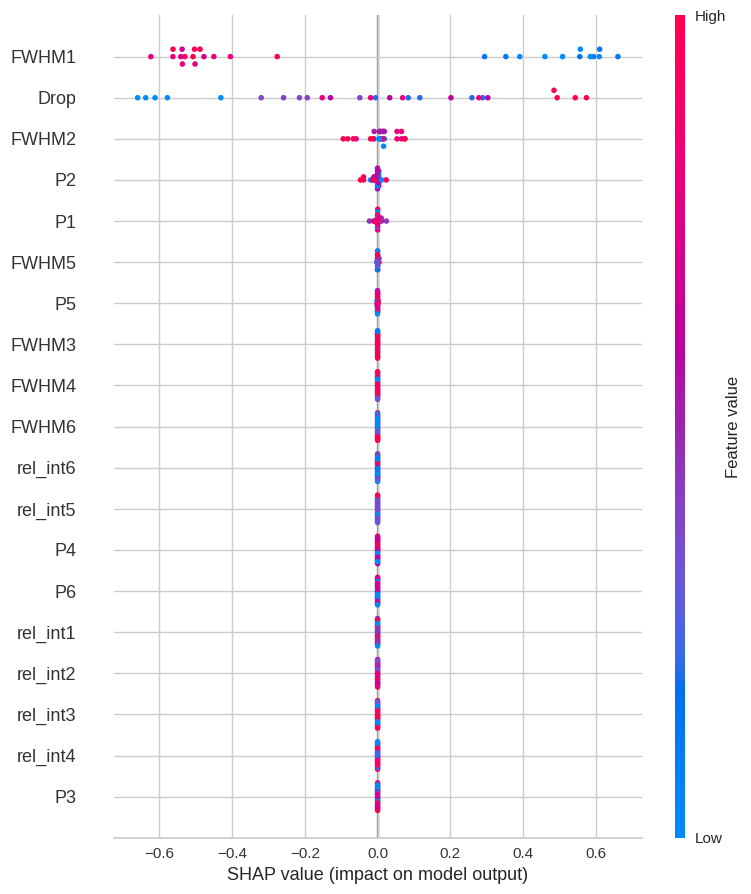

In [10]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X)

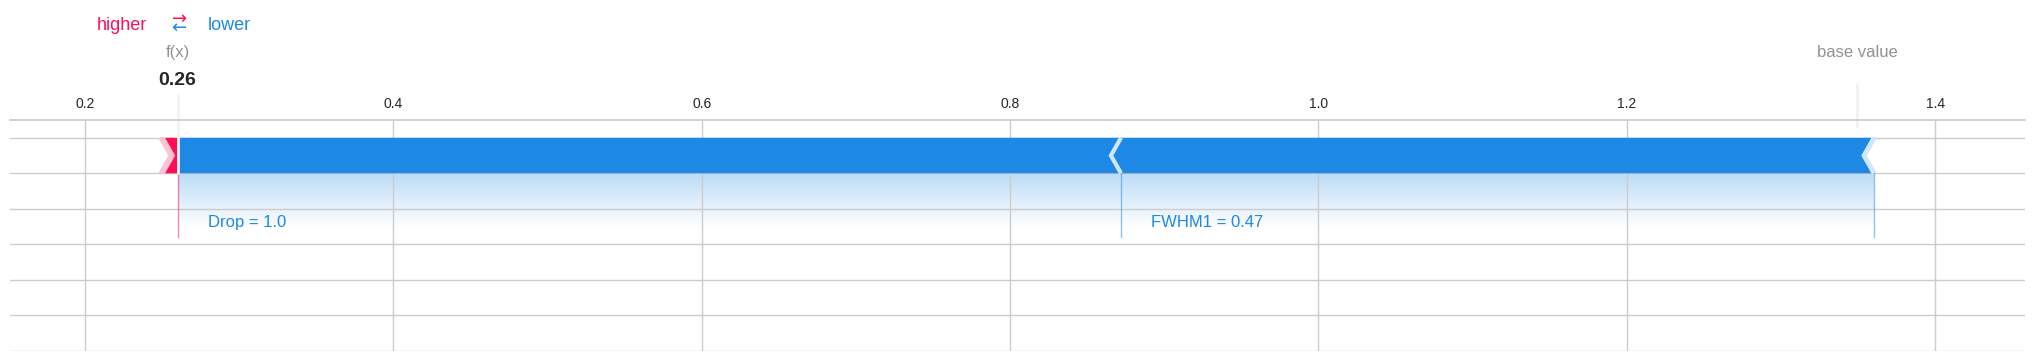

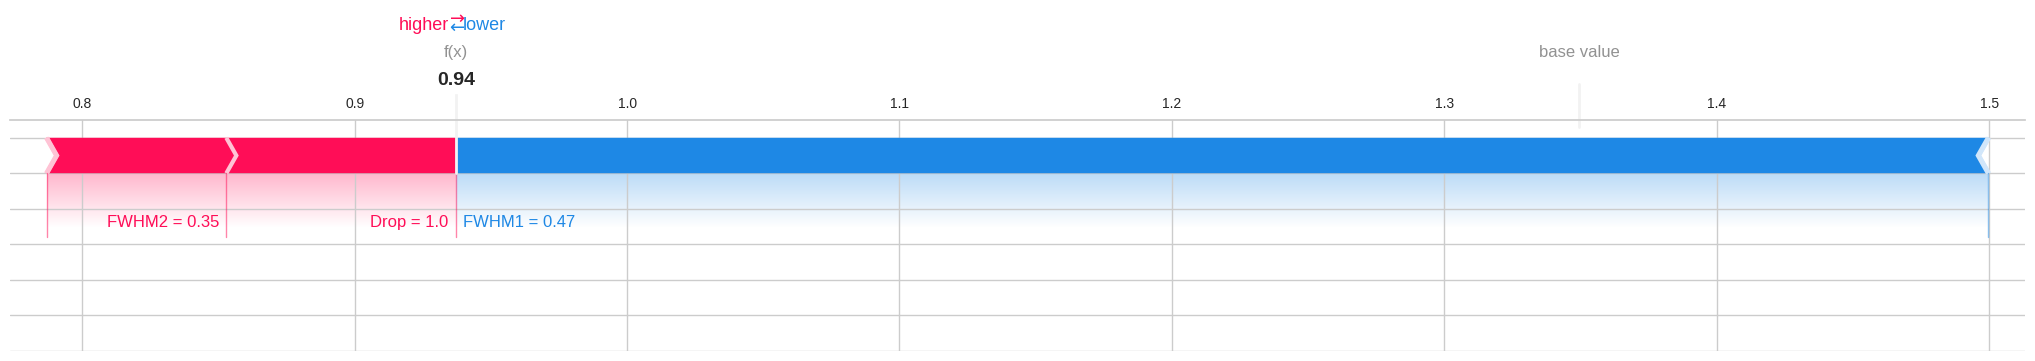

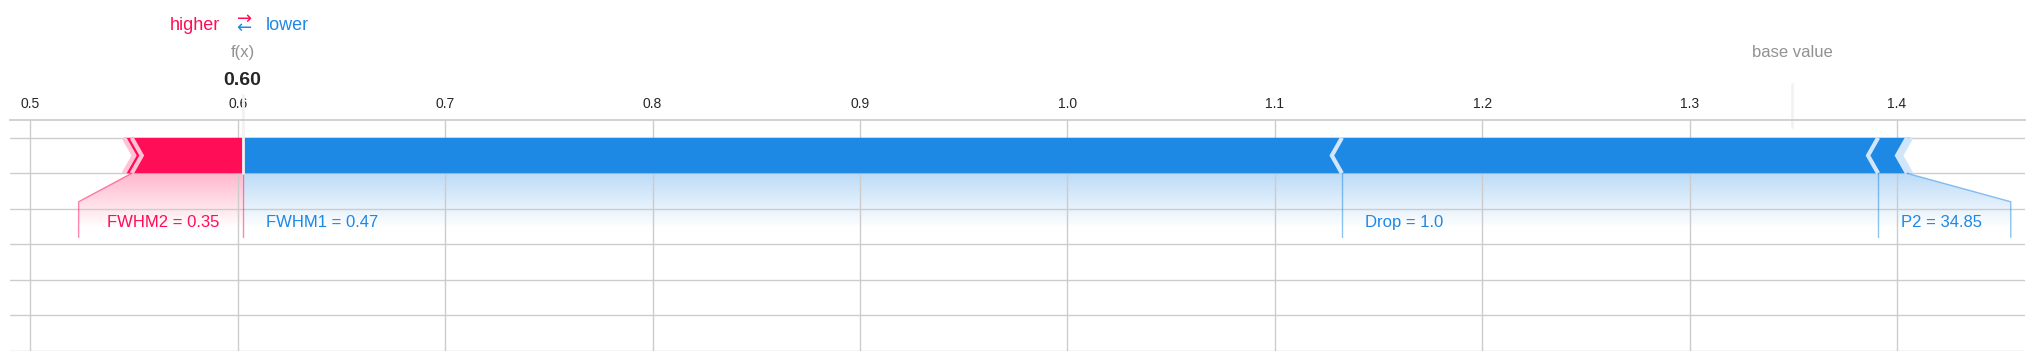

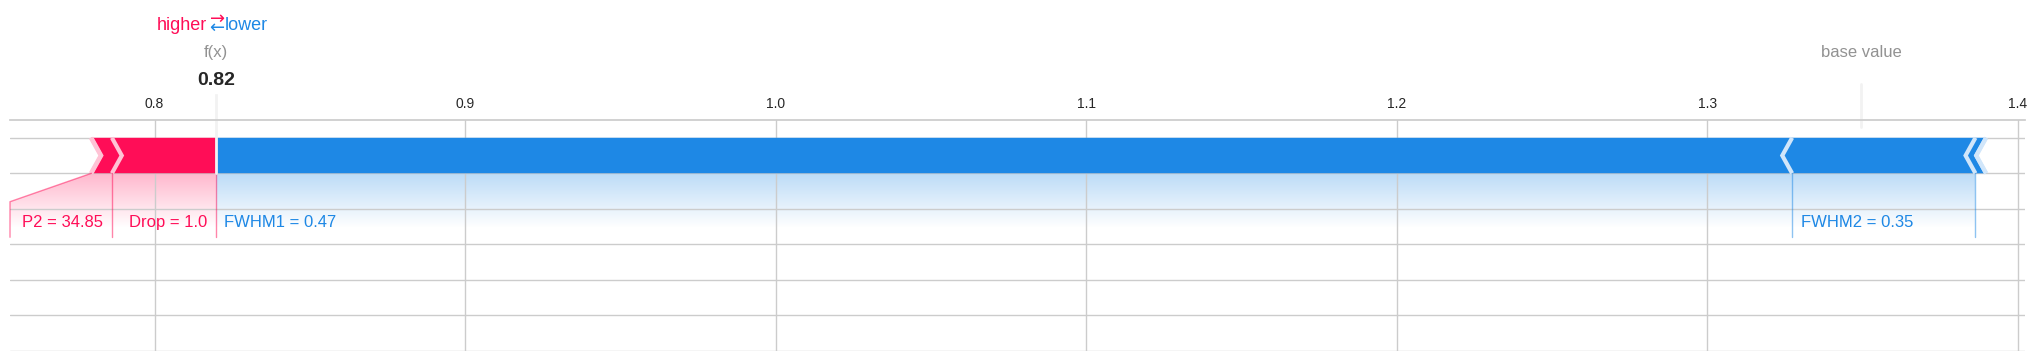

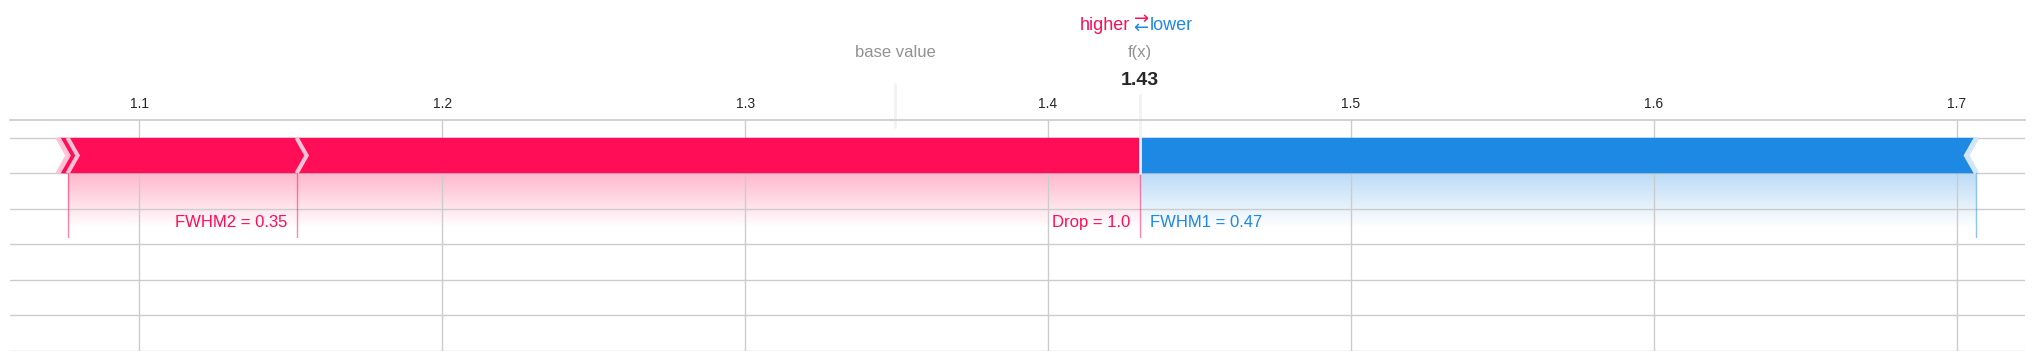

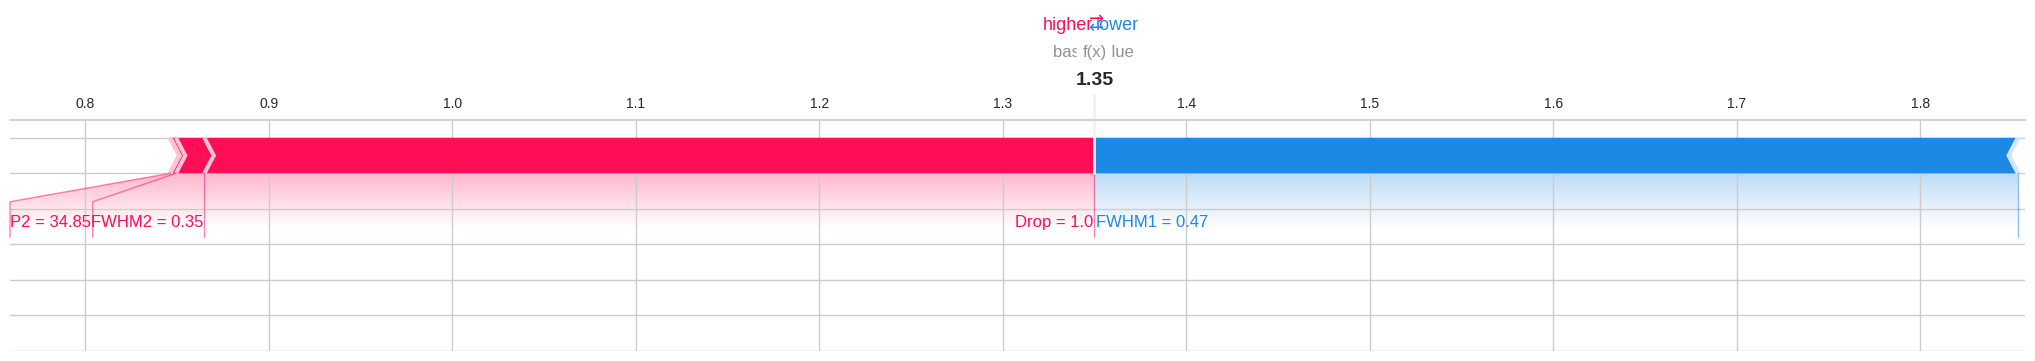

In [11]:
#Sample 1
for i in range(0,6):
  shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X.iloc[0],
    matplotlib=True,
    figsize=(26,3)
)

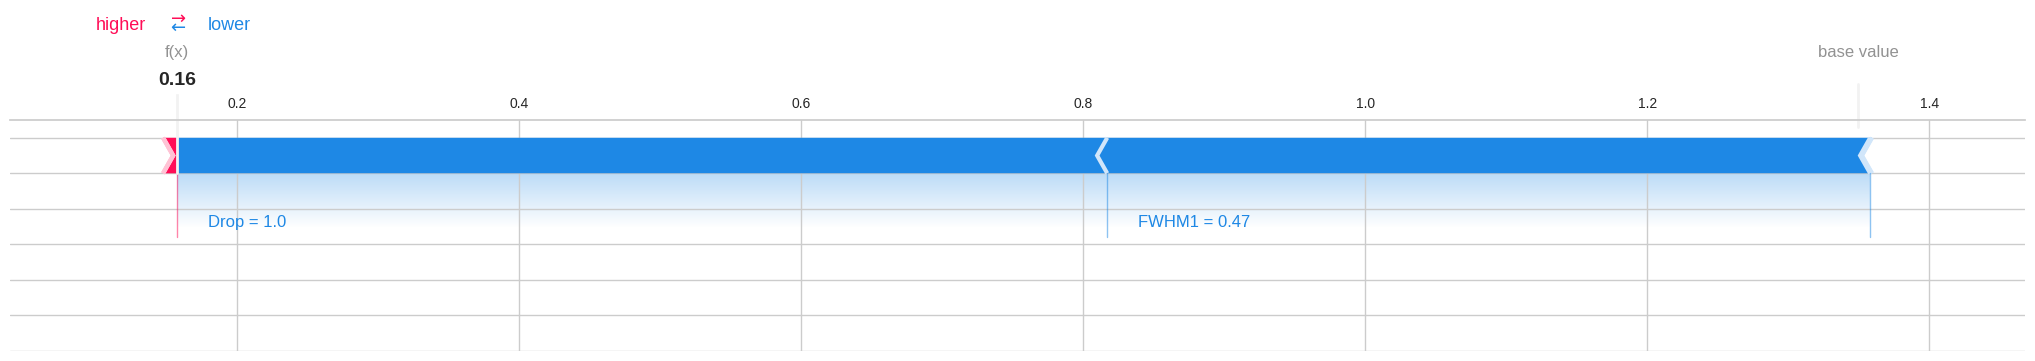

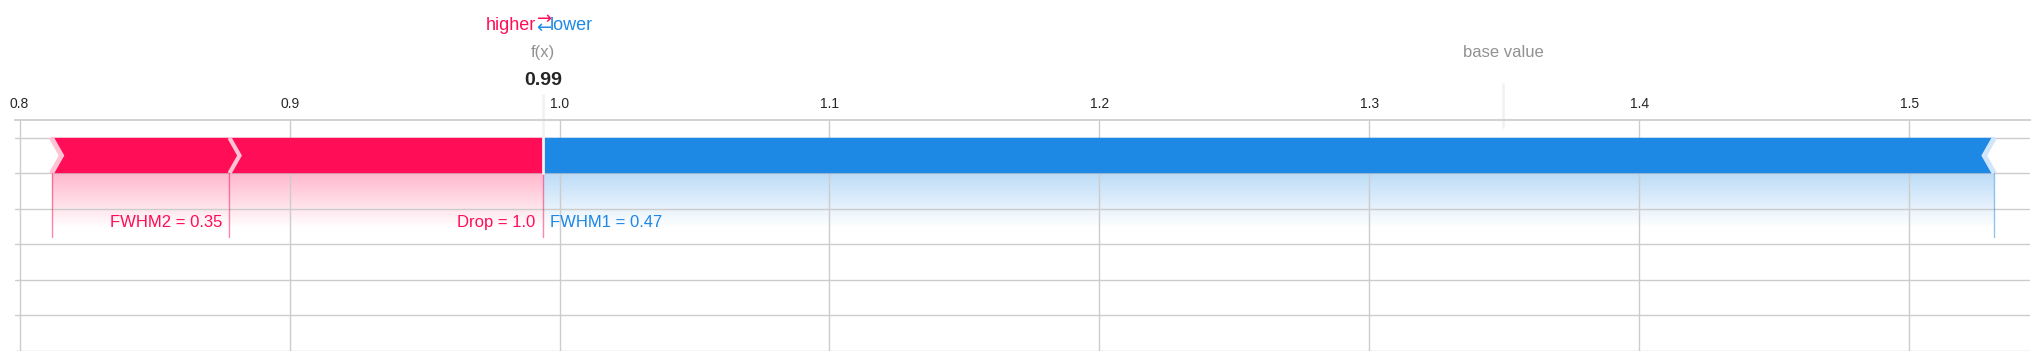

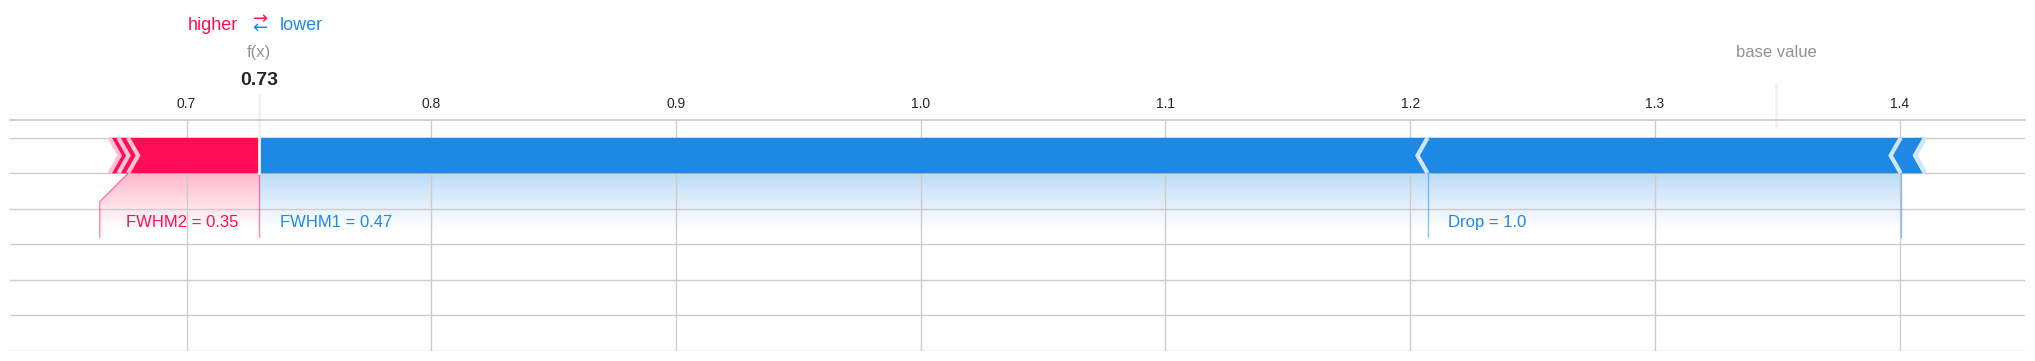

In [12]:
#Sample 2
for i in range(6,9):
  shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X.iloc[0],
    matplotlib=True,
    figsize=(26,3)
)

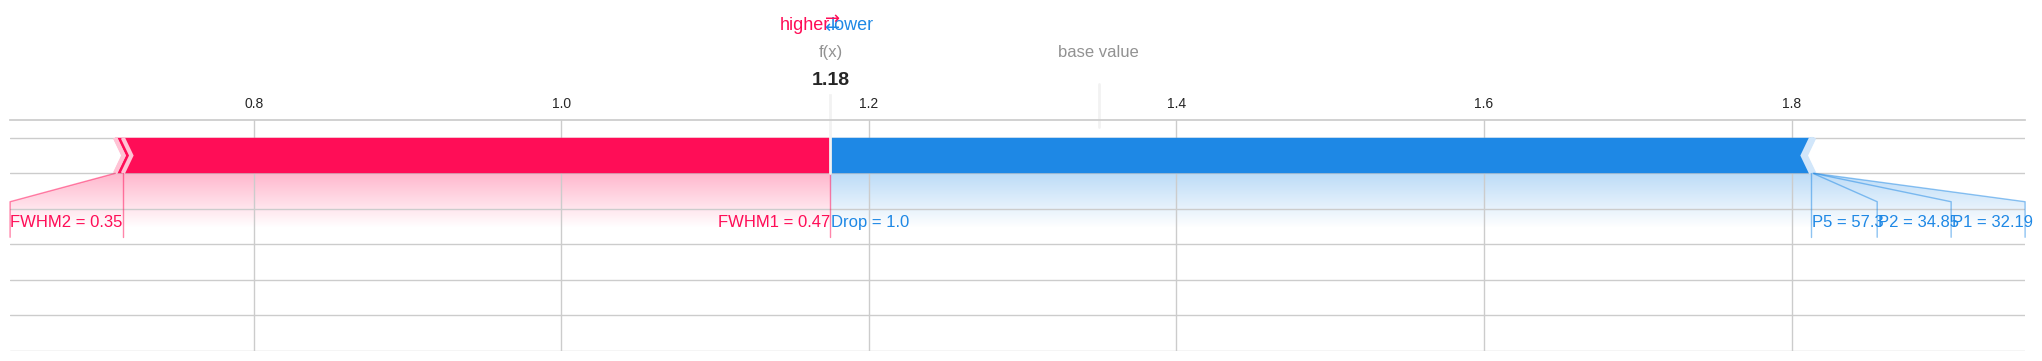

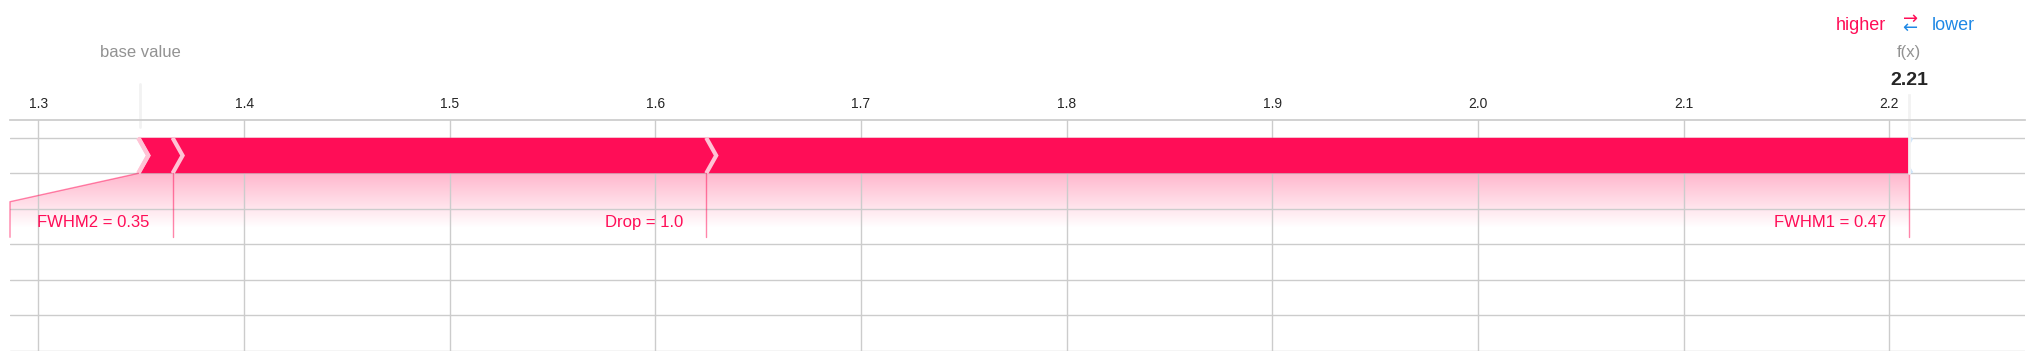

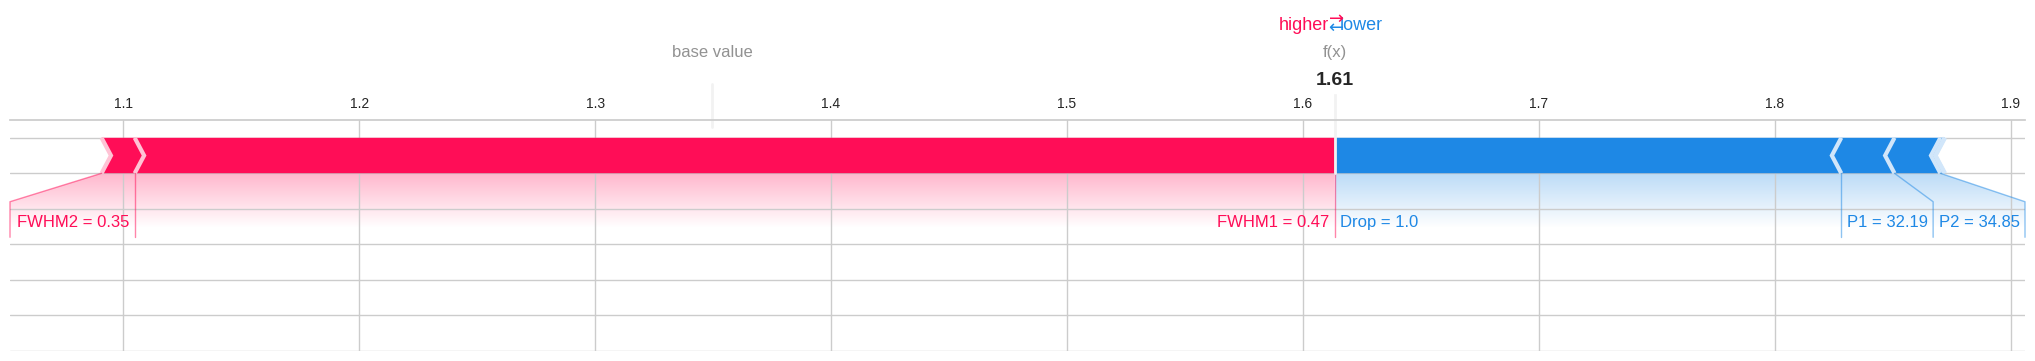

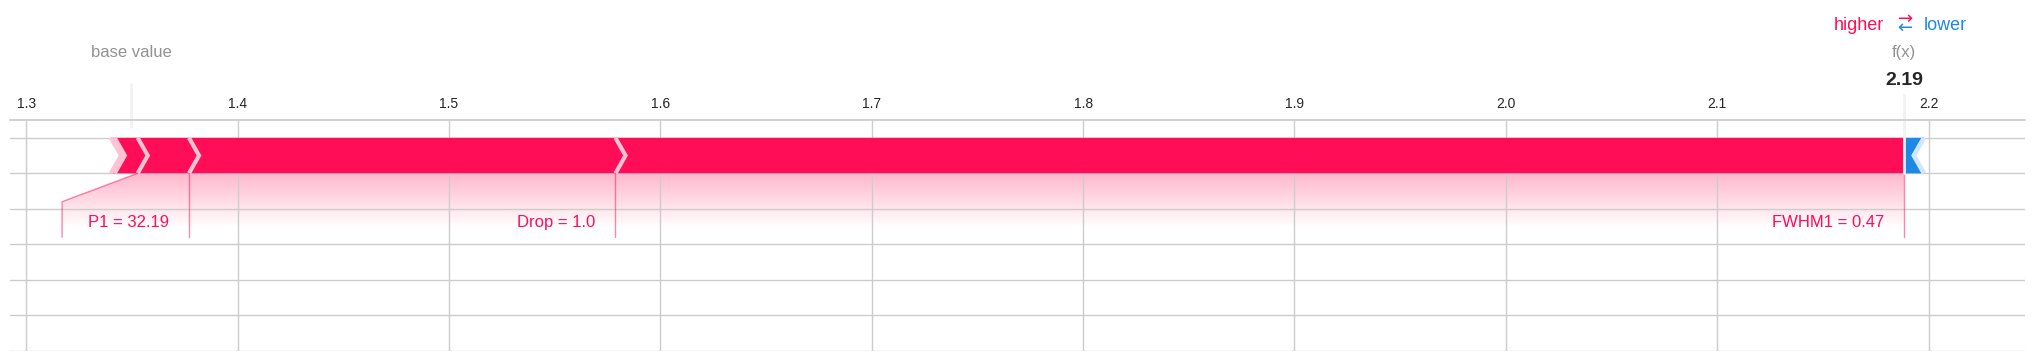

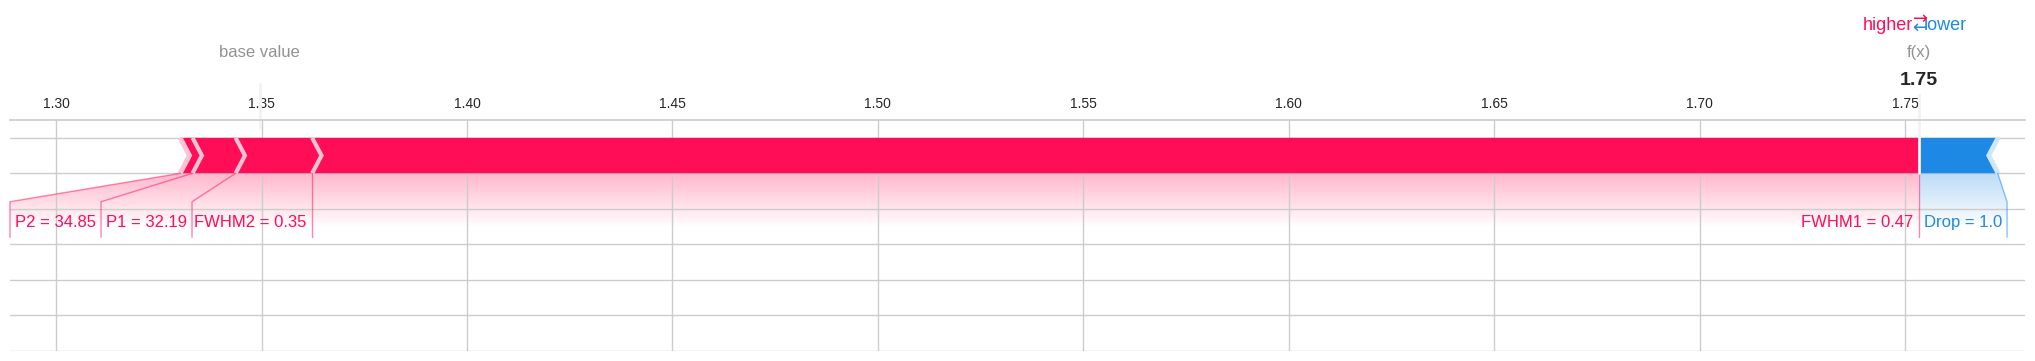

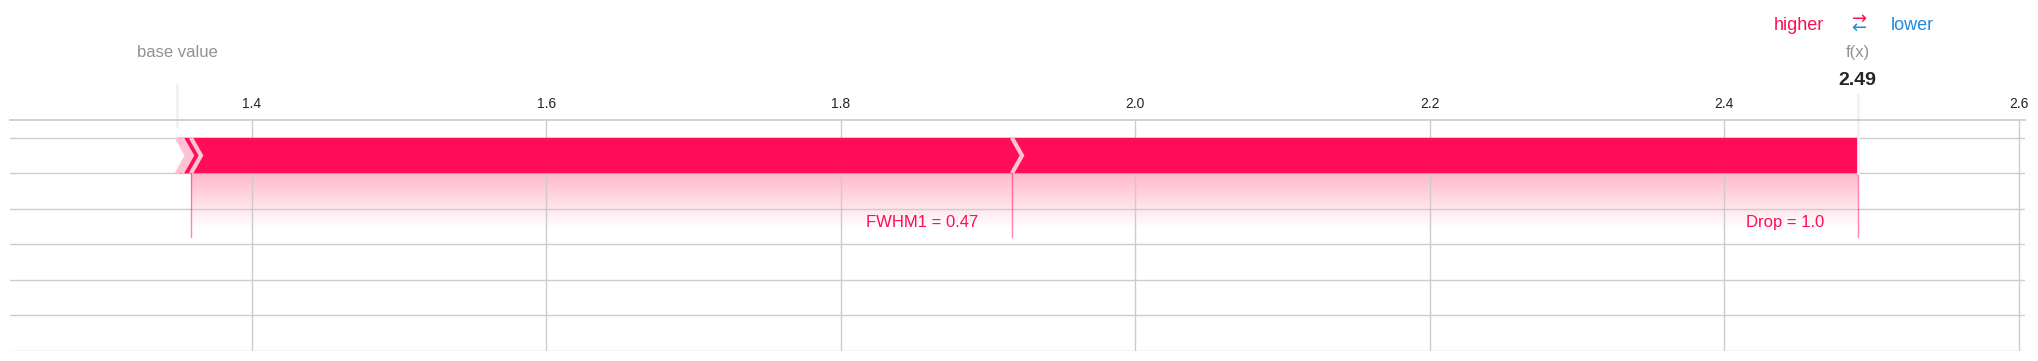

In [13]:
#Sample 3, Highest efficiency
for i in range(9,15):
  shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X.iloc[0],
    matplotlib=True,
    figsize=(26,3)
)

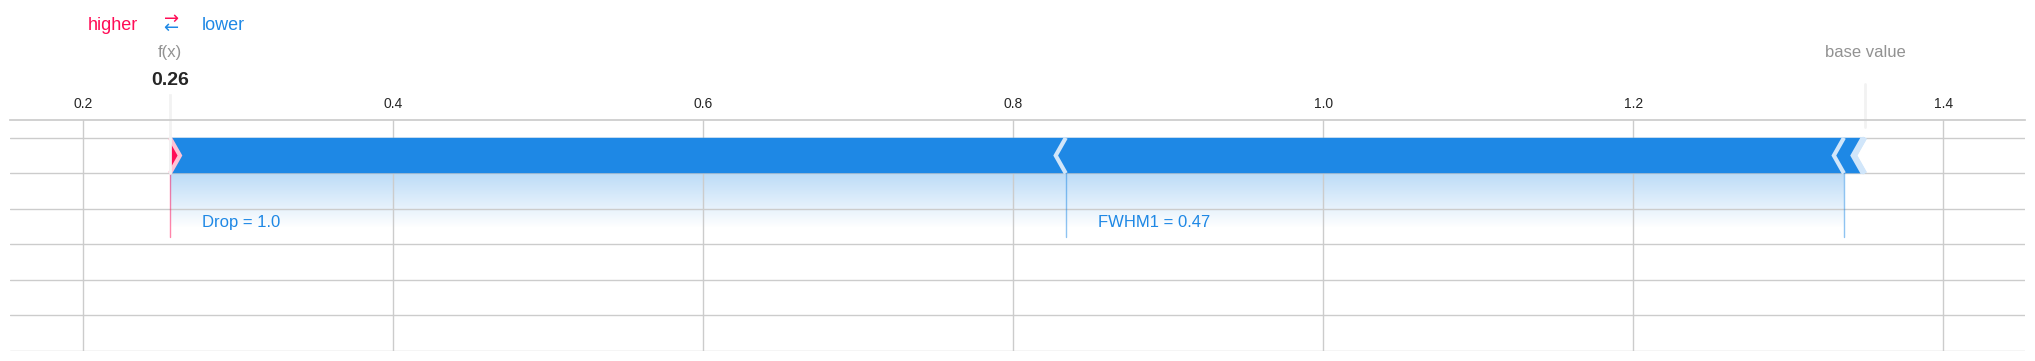

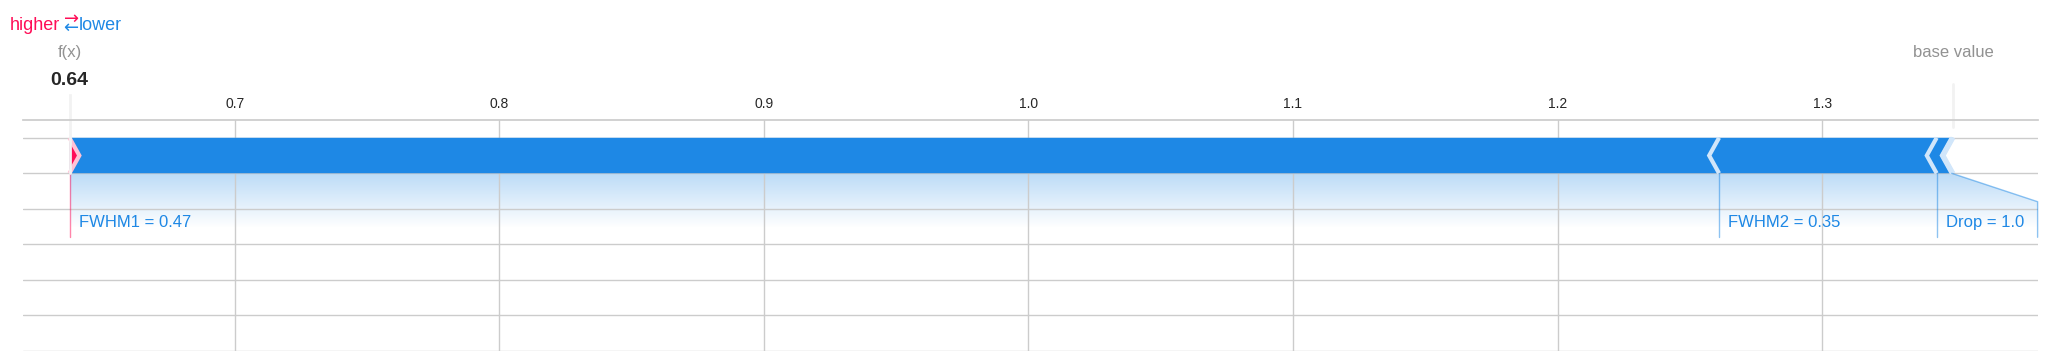

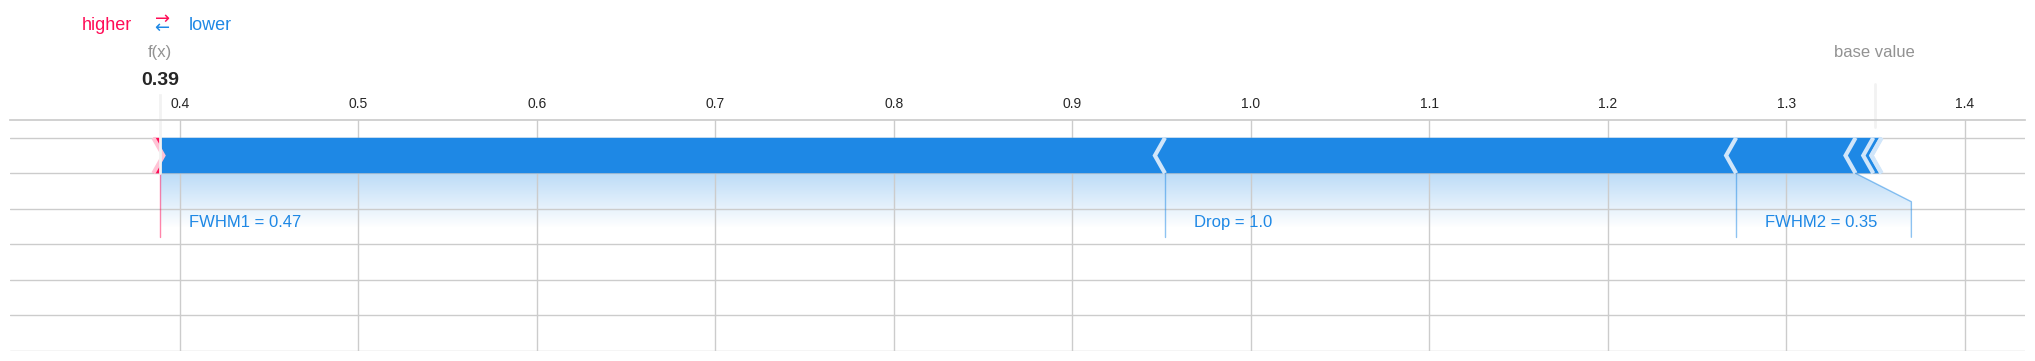

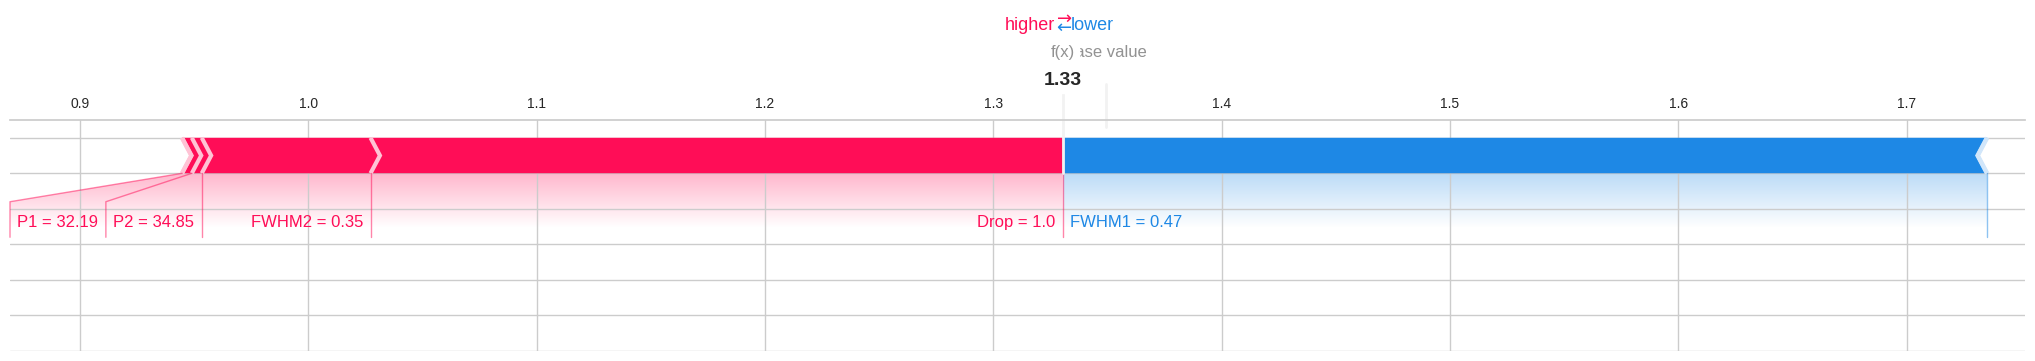

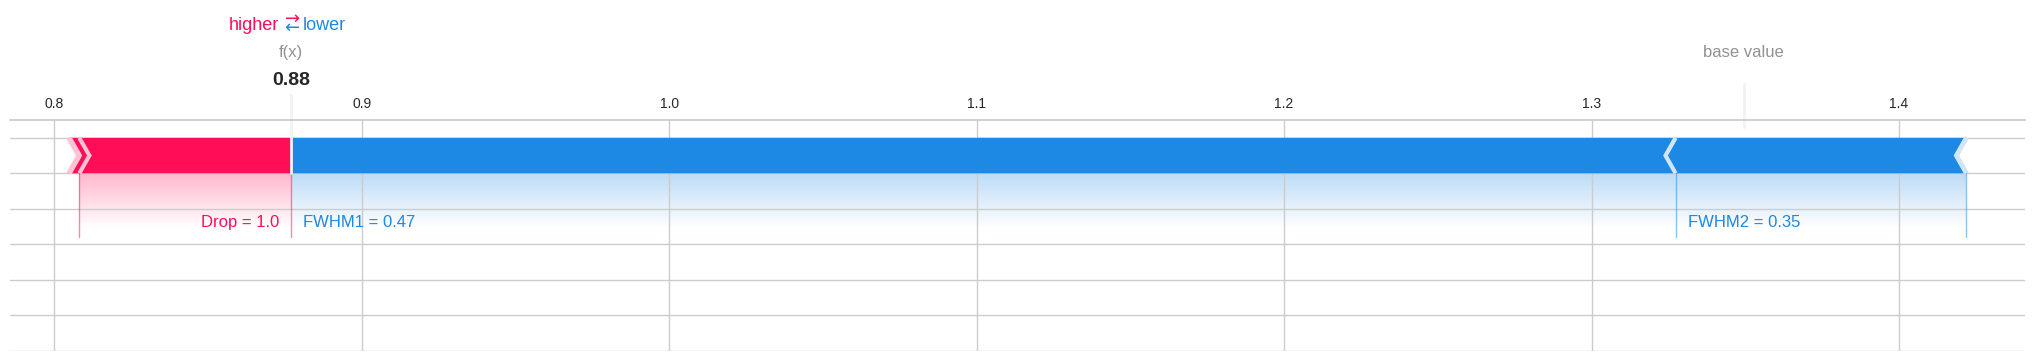

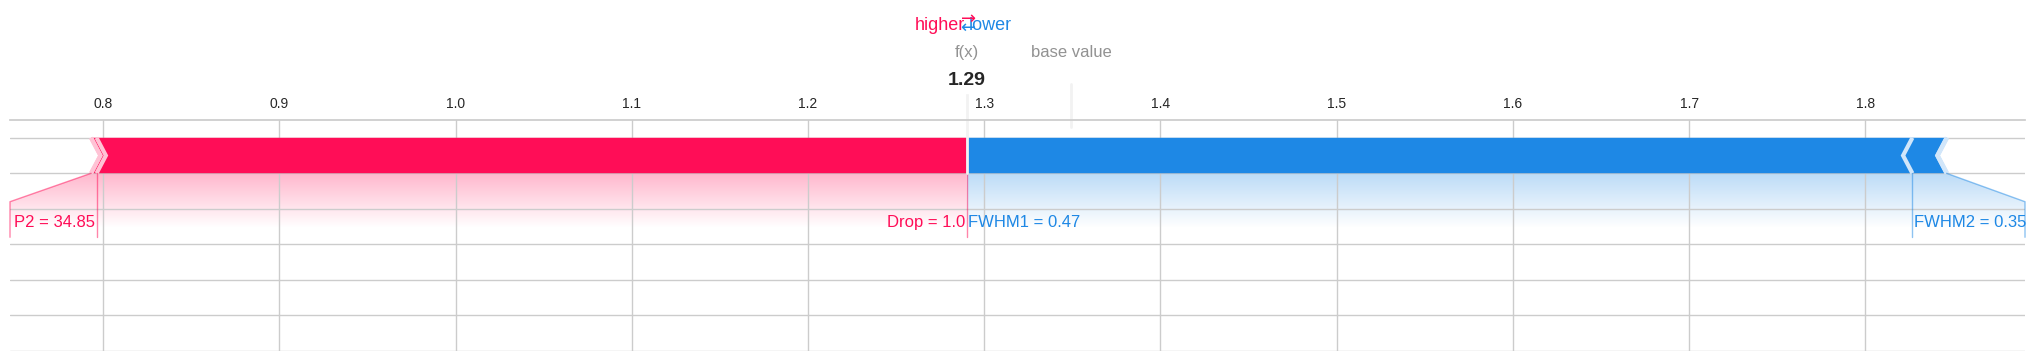

In [14]:
#Sample 4
for i in range(15,21):
  shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X.iloc[0],
    matplotlib=True,
    figsize=(26,3)
)

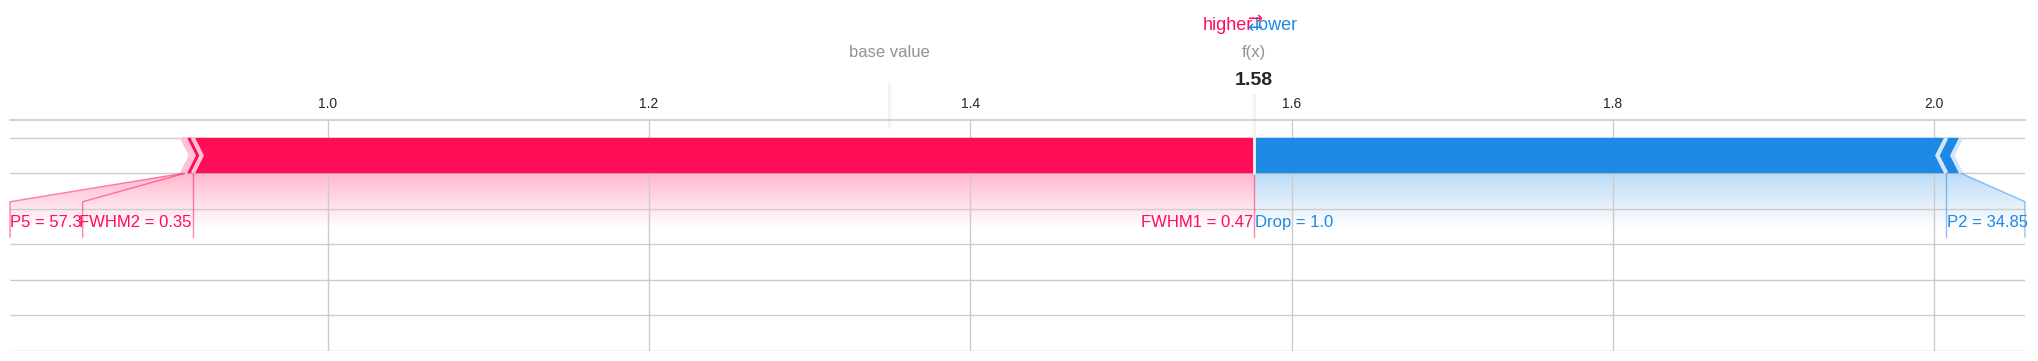

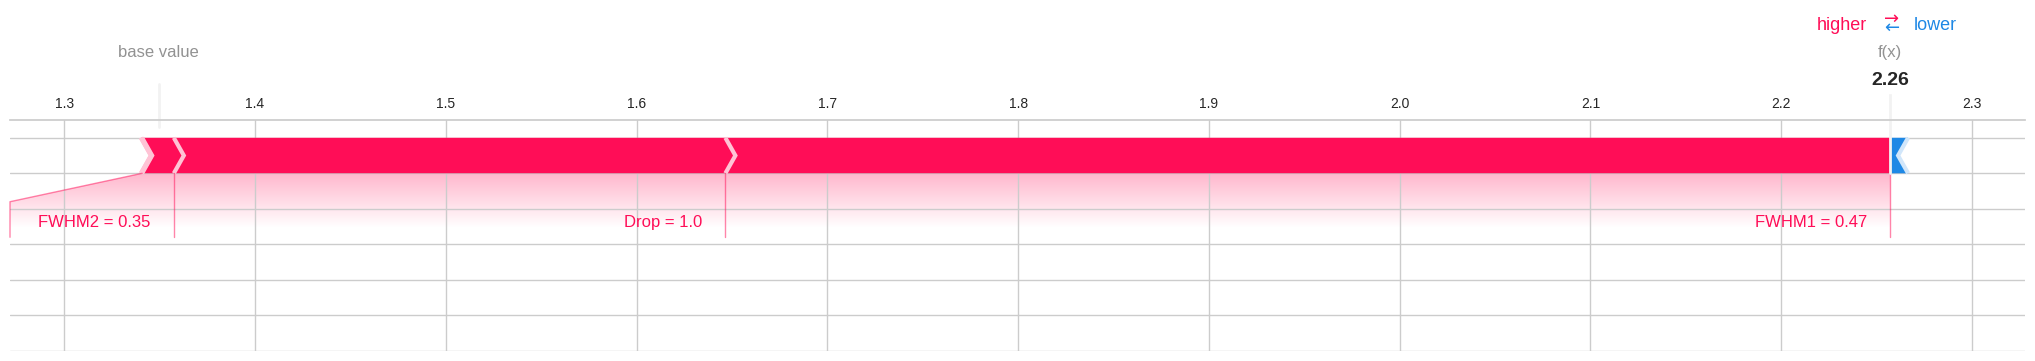

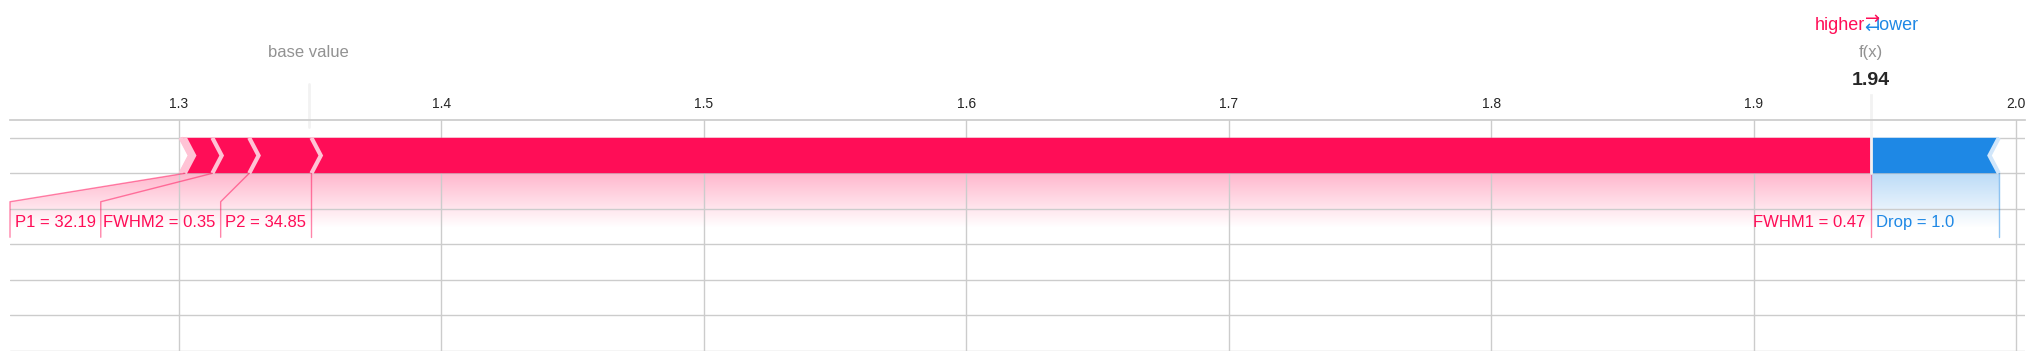

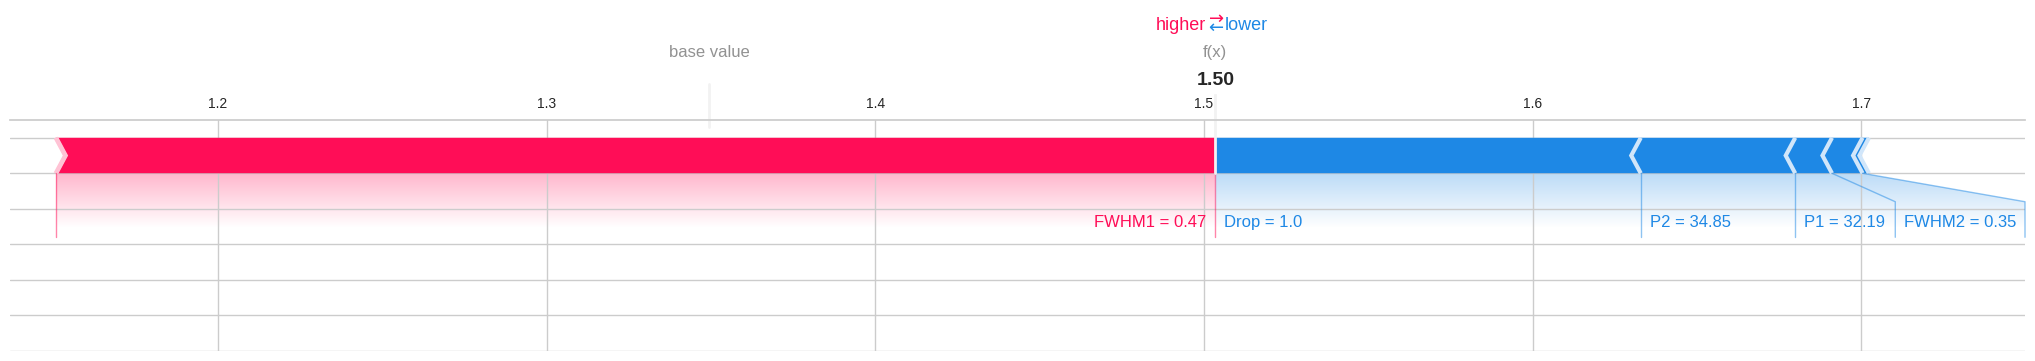

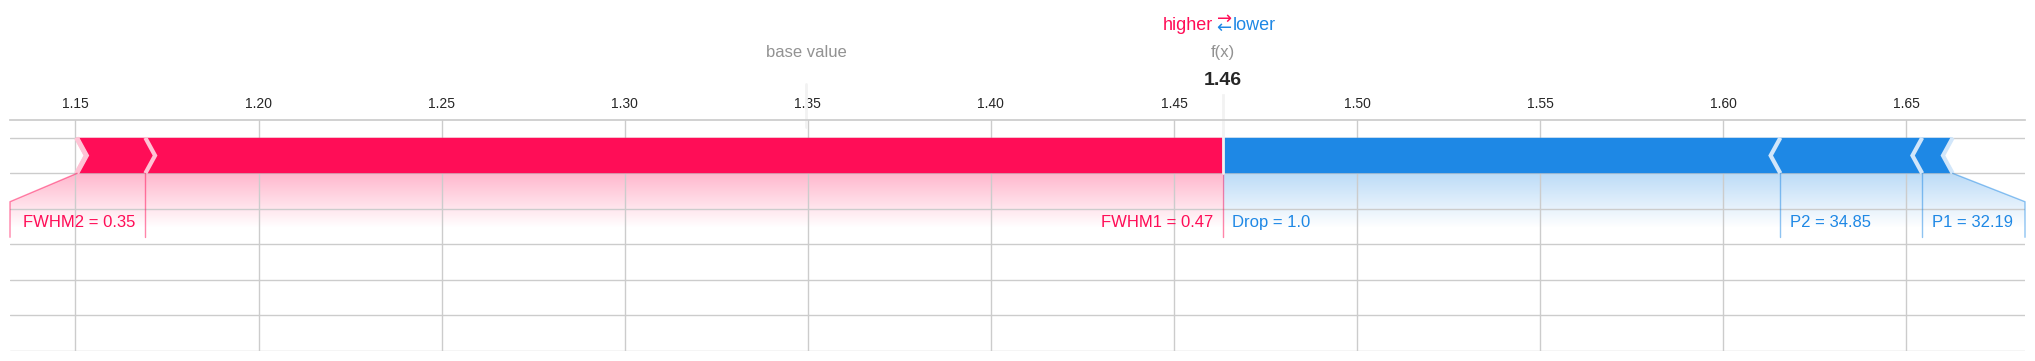

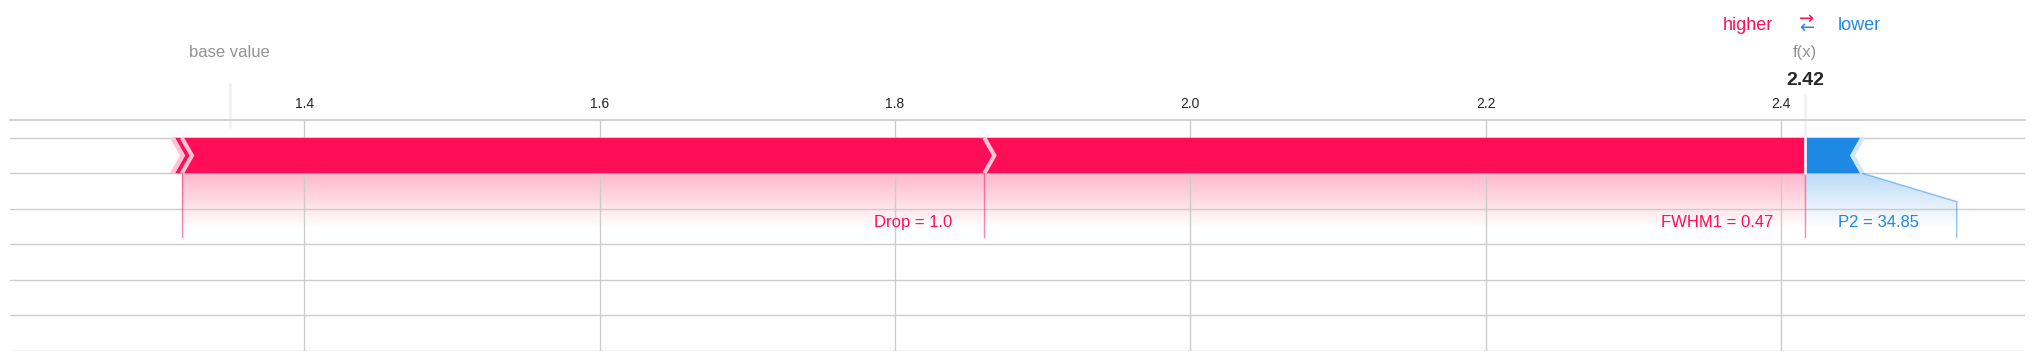

In [15]:
#Sample 5
for i in range(21,27):
  shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X.iloc[0],
    matplotlib=True,
    figsize=(26,3)
)

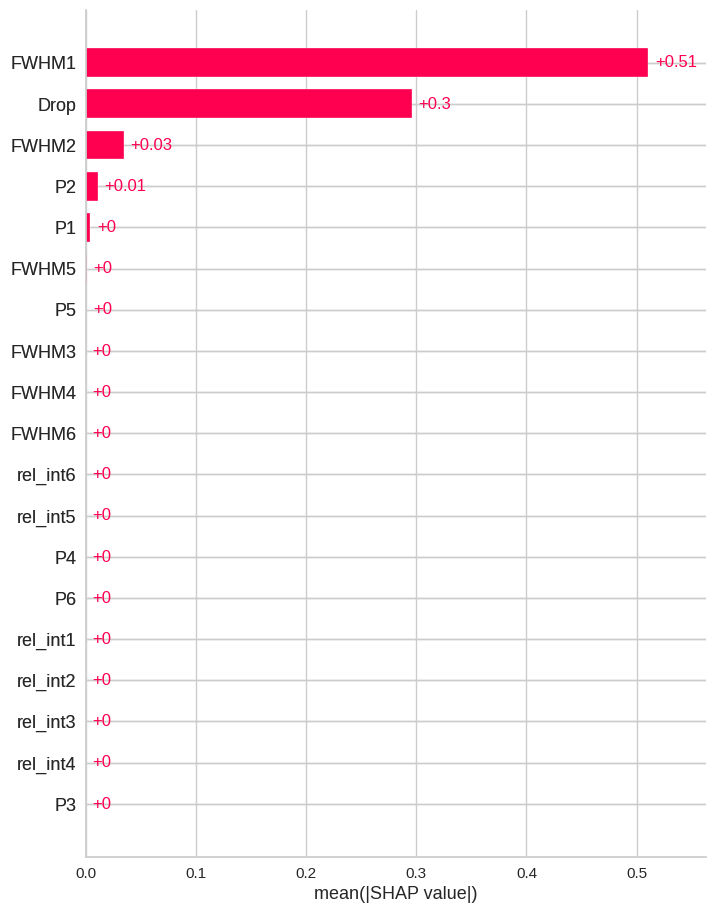

In [16]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.bar(shap_values,max_display=20)

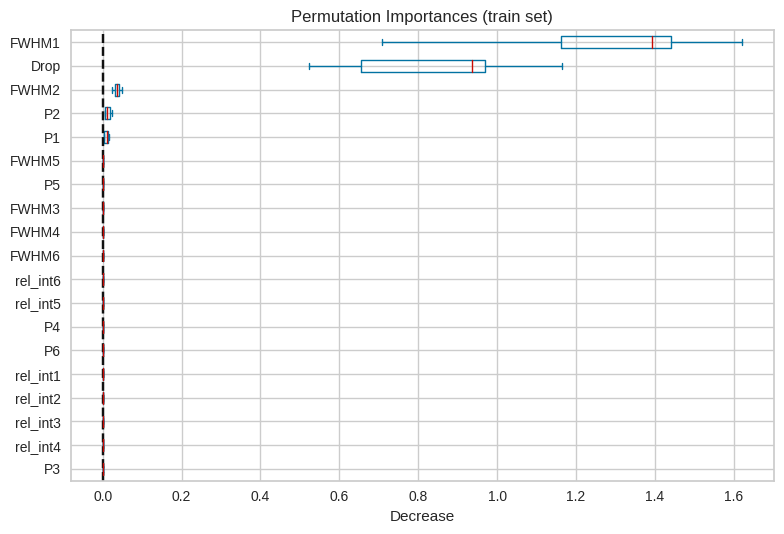

In [17]:
result = permutation_importance(
    model, X_train , y_train , random_state=78, n_jobs=2)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease")
ax.figure.tight_layout()

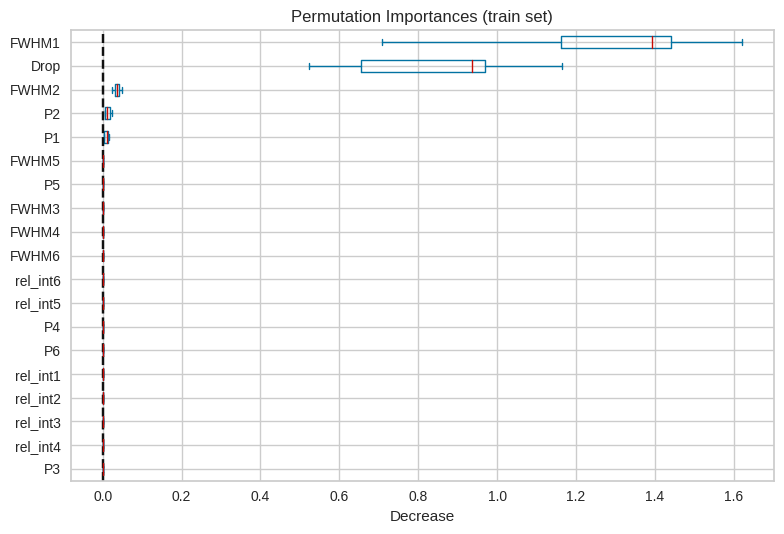

In [18]:
result = permutation_importance(
    model, X_train , y_train , random_state=78, n_jobs=2)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease")
ax.figure.tight_layout()